In [1]:
import os
import sys
import pickle
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import model

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
import random
def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3Q
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6

In [3]:
manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 64
val_batch_size = 256

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 1

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

# 학습할 에폭 수
num_epochs = 20

# 옵티마이저의 학습률
lr = 0.0001

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomCrop((32,32),padding=2),
    transforms.ToTensor(),
    # transforms.Resize((32,32)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data',train=True, download=False, transform=train_transforms)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

val_transforms = transforms.Compose([
    transforms.RandomCrop((32,32),padding=2),
    transforms.ToTensor(),
    # transforms.Resize((32,32)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

val_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False,download=False ,transform=val_transforms)
val_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



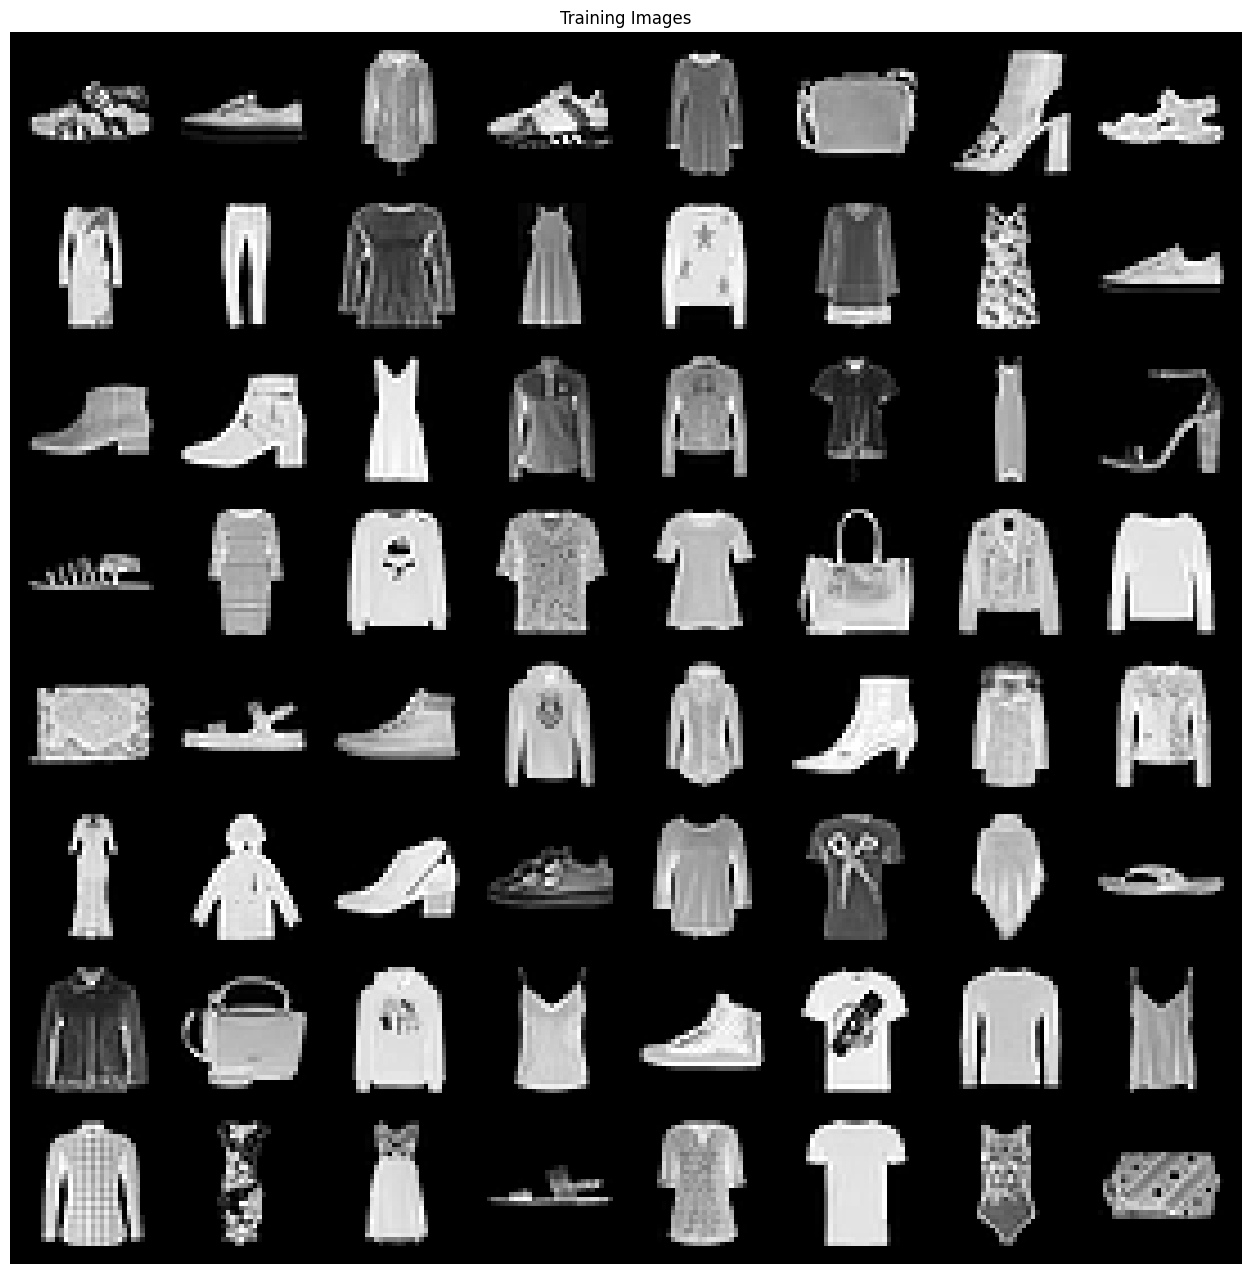

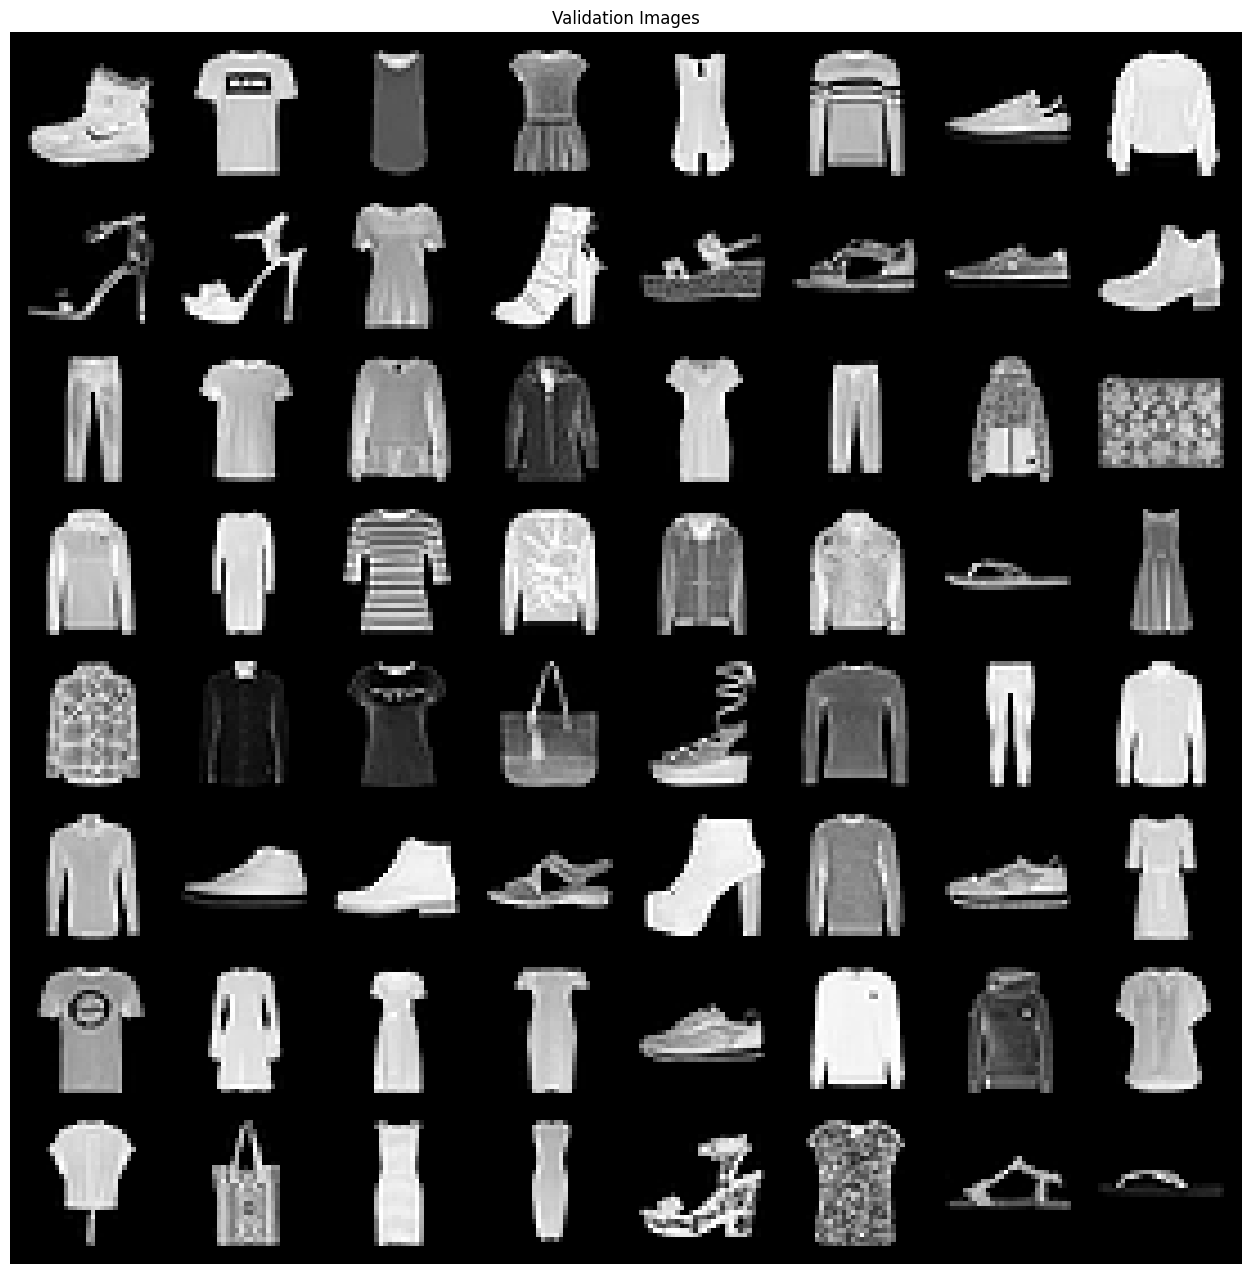

In [5]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize
import torchvision.utils as vutils
imgs, labels= next(iter(train_loader))
print()
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(imgs.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

imgs, labels= next(iter(val_loader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Validation Images")
plt.imshow(np.transpose(vutils.make_grid(imgs.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# ``netG`` 와 ``netD`` 에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
netG = model.Generator(nc,nz,ngf)
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [8]:
netD = model.Discriminator(nc,ndf)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [9]:
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다.
fixed_noise = torch.randn(12, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
img_list = []
G_losses = []
D_losses = []
netG.to(device)
netD.to(device)
print("Starting Training Loop...")
for epoch in range(num_epochs):
    total_g_loss = 0
    total_d_loss = 0
    for i, data in enumerate(train_loader):
        # D 모델 학습 log(D(x)) + log(1-D(G(z)))를 최대화 합니다
        # 진짜 데이터들을 사용하여 학습합니다
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device = device)
        # print(real_cpu.shape)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 가짜 데이터로 학습합니다
        noise= torch.randn(b_size, nz, 1,1, device=device)
        # G를 이용해 가짜 이미지 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        output=netD(fake.detach()).view(-1)
        errD_fake = criterion(output,label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        errD = errD_real + errD_fake
        optimizer_D.step()

        # ------------------------------------------
        # G 모델을 업데이트합니다. log(D(g(z)))를 최대화합니다
        netG.zero_grad()
        label.fill_(real_label)
        # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용
        # D를 업데이트 했기때문에 D에 다시 가짜 데이터를 통과시킨다
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞의 손실값과 다르다. errD_fake
        output = netD(fake).view(-1)
        errG = criterion(output,label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()

        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        total_g_loss += errG.item()
        total_d_loss += errD.item()

    total_g_loss /= len(train_loader)
    total_d_loss /= len(train_loader)
    # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
    G_losses.append(total_g_loss)
    D_losses.append(total_d_loss)

    # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
    if (epoch % 2 == 0):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, nrow=4, padding=2, normalize=True))

Starting Training Loop...
[0/20][0/938]	Loss_D: 1.6934	Loss_G: 1.2898	D(x): 0.3521	D(G(z)): 0.3873 / 0.3145
[0/20][200/938]	Loss_D: 0.2393	Loss_G: 2.7882	D(x): 0.8526	D(G(z)): 0.0558 / 0.0851
[0/20][400/938]	Loss_D: 0.1140	Loss_G: 2.6406	D(x): 0.9636	D(G(z)): 0.0700 / 0.0981
[0/20][600/938]	Loss_D: 0.7747	Loss_G: 0.7855	D(x): 0.5402	D(G(z)): 0.0071 / 0.5278
[0/20][800/938]	Loss_D: 0.2904	Loss_G: 4.9718	D(x): 0.9878	D(G(z)): 0.2242 / 0.0106
[1/20][0/938]	Loss_D: 0.2466	Loss_G: 2.8959	D(x): 0.8382	D(G(z)): 0.0454 / 0.0881
[1/20][200/938]	Loss_D: 0.3124	Loss_G: 4.2112	D(x): 0.9591	D(G(z)): 0.2184 / 0.0197
[1/20][400/938]	Loss_D: 0.2401	Loss_G: 3.1873	D(x): 0.9434	D(G(z)): 0.1565 / 0.0545
[1/20][600/938]	Loss_D: 0.6966	Loss_G: 0.8672	D(x): 0.5920	D(G(z)): 0.0559 / 0.4864
[1/20][800/938]	Loss_D: 0.3205	Loss_G: 1.8961	D(x): 0.8163	D(G(z)): 0.0930 / 0.1854
[2/20][0/938]	Loss_D: 0.7209	Loss_G: 0.8398	D(x): 0.5684	D(G(z)): 0.0594 / 0.4842
[2/20][200/938]	Loss_D: 1.1063	Loss_G: 0.7290	D(x): 0.39

Loss 그래프프

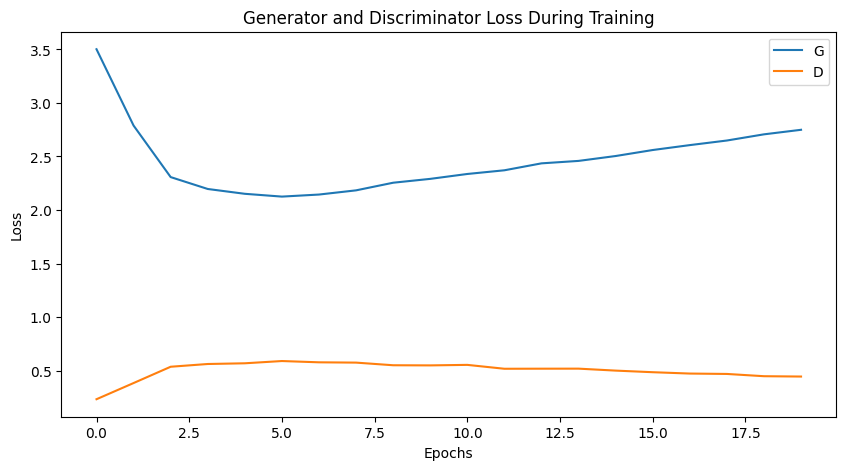

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

epoch 당 이미지

10
torch.Size([3, 70, 274])


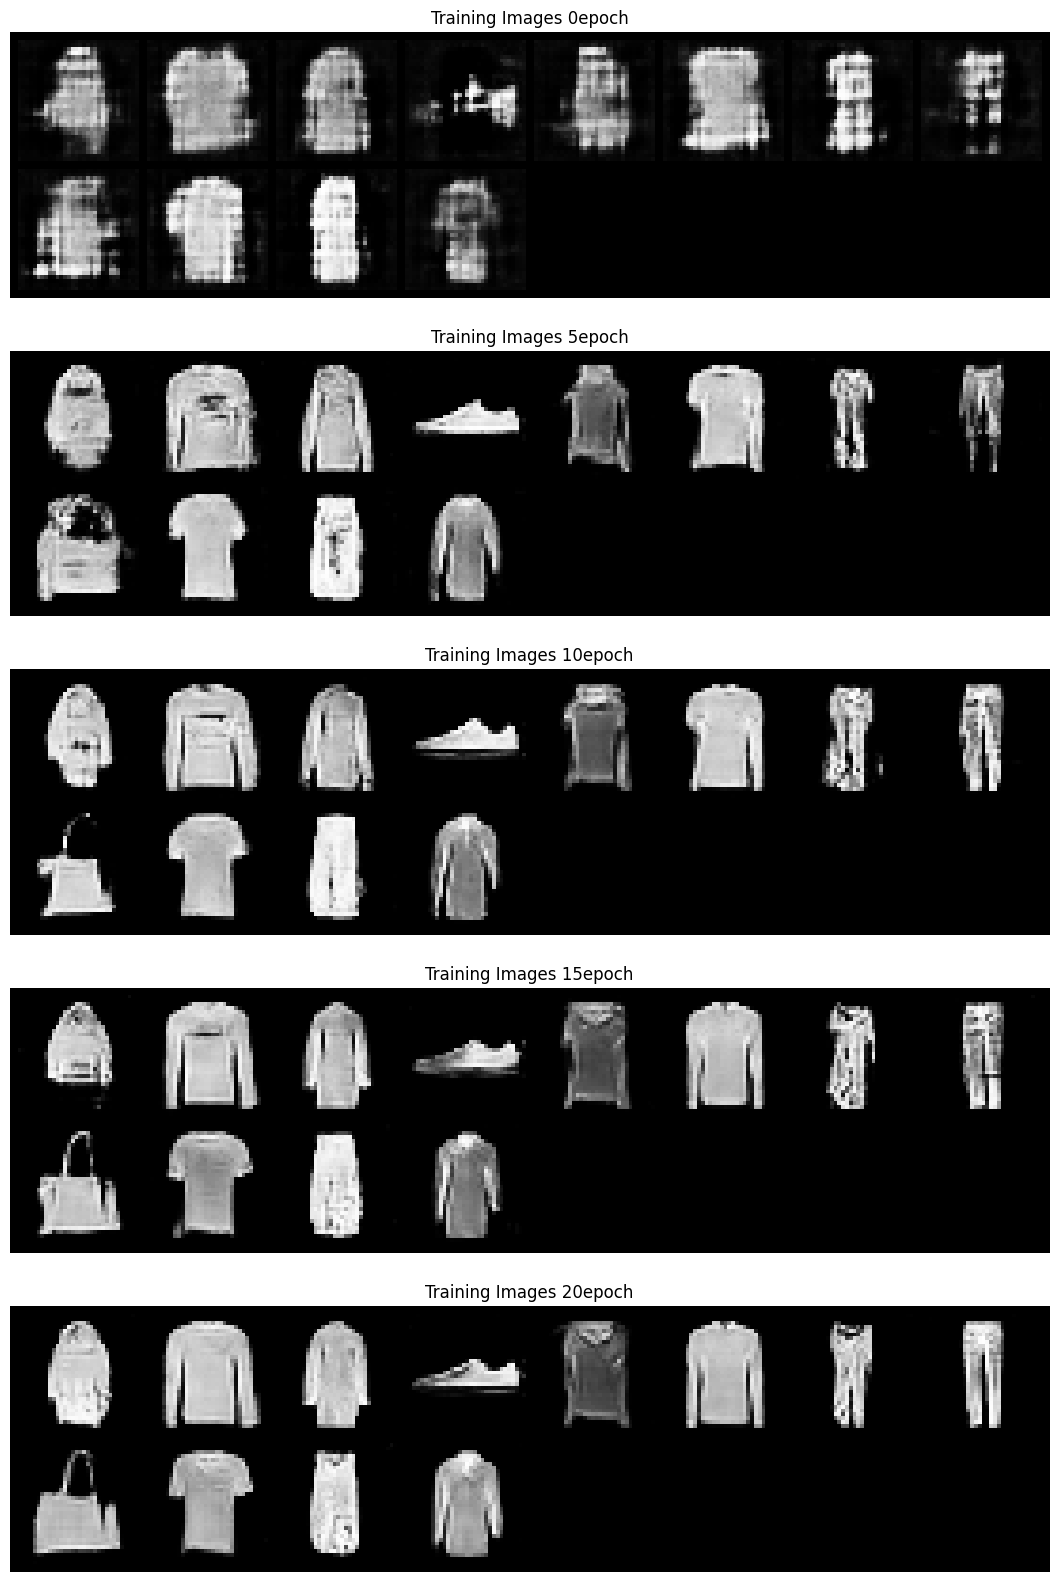

In [15]:
print(len(img_list))
print(img_list[0].shape)
plt.figure(figsize=(100,20))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.axis("off")
    plt.title(f"Training Images {i*5}epoch")
    plt.imshow(np.transpose(img_list[i*2],(1,2,0)))


진짜 vs 가짜

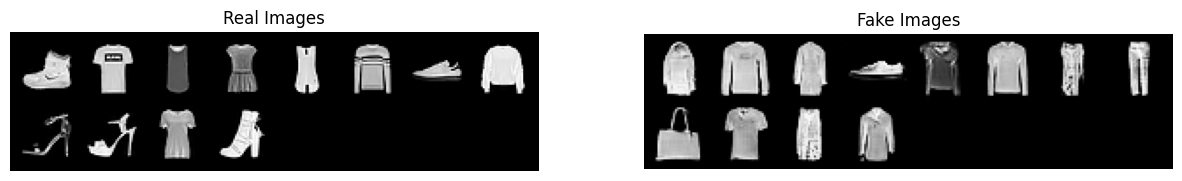

In [13]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(val_loader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:12], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()